# 全卷积神经网络


语义分割是对图像中的每个像素分类。全卷积网络（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换。与之前学习的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这里需要引入转置卷积（transposed convolution）来实现的。因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。


In [4]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 构造模型

下面我们来了解一下全卷积网络模型最基本的设计。如下图所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过卷积层将通道数变换为类别个数，最后在通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。
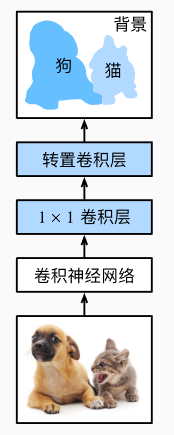

下面，我们使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络记为pretrained_net。 ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [9]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

接下来，我们创建一个全卷积网络net。 它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。也就是除了上面最后两排，我们都需要。这就很简单了，列表取到-2就可。

In [10]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])
print(net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的1/32，即10和15。

In [11]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

然后，采用1 x 1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。最后需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。

卷积层输出形状的计算方法：

(320-64+16* 2+32)/32=10                                                             
(480-64+16* 2+32)/32=15

我们构造一个步幅为32的转置卷积层，并将卷积核的高和宽设为64，填充为16。我们可以看到如果步幅为s，填充为s/2
（假设s/2是整数）且卷积核的高和宽为2s，转置卷积核会将输入的高和宽分别放大s倍。


In [12]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## 初始化转置卷积层
在图像处理中，有时需要将图像放大，即上采样（upsampling）。双线性插值（bilinear interpolation）是常用的上采样方法之一，它也经常用于初始化转置卷积层。
为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1. 将输出图像的坐标(x,y)映射到输入图像的坐标(x1,y1)上。例如，根据输入与输出的尺寸之比来映射。 请注意，映射后的x1和y1是实数。

2. 在输入图像上找到离坐标(x1,y1)最近的4个像素。

3. 输出图像在坐标(x,y)上的像素依据输入图像上这4个像素及其与(x1,y1)的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造。 限于篇幅，我们只给出bilinear_kernel函数的实现，不讨论算法的原理。

In [13]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用双线性插值的上采样实验它由转置卷积层实现。 我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。

In [14]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。

In [15]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


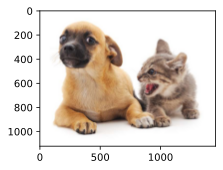

In [16]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

全卷积网络用双线性插值的上采样初始化转置卷积层。对于卷积层，我们使用Xavier初始化参数。

In [17]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## 读取数据集

指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。


In [6]:
def load_data_voc(batch_size, crop_size, is_download=True, url='./data//VOCdevkit//VOC2012'):
    """
    下载并读取Pascal VOC2012语义分割数据集,提供url可免去下载
    :param batch_size: 批量大小
    :param crop_size: 裁剪大小,比如(320, 480)
    :return: 返回训练集和测试集的数据迭代器
    """
    if is_download:
        voc_dir = d2l.download_extract('voc2012', os.path.join(
            'VOCdevkit', 'VOC2012'))
    else:
        voc_dir = url
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [7]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size, is_download=False)

read 1114 examples
read 1078 examples


## 训练
现在我们可以训练全卷积网络了。这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。此外，模型基于每个像素的预测类别是否正确来计算准确率。

loss 0.418, train acc 0.869, test acc 0.852
2.2 examples/sec on [device(type='cpu')]


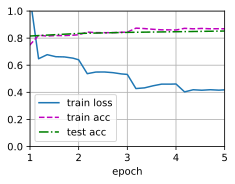

In [18]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 预测
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [19]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了可视化预测的类别给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。

In [20]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

测试数据集中的图像大小和形状各异。
由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。
为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。
请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为`softmax`运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。
对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。

In [ ]:
voc_dir = './data//VOCdevkit//VOC2012'
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);